In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

# 5.2 - Utilização de redes convolutivas em pequenos conjuntos de dados

## Treinando uma rede convolutiva a partir do zero em um pequeno conjunto de dados


No contexto de uma rede neural convolutiva, uma "pequena" quantidade de amostras pode ser um número que vai de poucas dezenas até alguns milhares de imagens. 

O exemplo a seguir irá treinar uma rede neural para classificar um conjunto de imagens em dois grupos: "dogs" ou "cats". O dataset contém 4.000 imagens (2.000 de cada grupo). Serão utilizadas 2.000 imagens para treino, 1.000 para validação e 1.000 para teste.

O primeiro modelo irá treinar uma pequena convnet nas 2.000 imagens de treino, sem qualquer regularização. Isto irá formar a base de desempenho. A precisão no conjunto de teste será de aprox.70%. 

Esta baixa precisão irá ocorrer por causa do overfit. Para lidar com o overfit em uma convnet existe a técnica de *data augmentation*. Através do uso desta técnica a precisão da rede atingirá aprox.80%.

A seguir serão apresentadas duas outras técnicas para lidar com o overfit em pequenos conjuntos de dados: *extração de features em uma rede pré-treinada* (o que irá levar a precisão para aprox.90%) e o *ajuste fino de uma rede pré-treinada* (o que leverá a precisão para aprox.95%).

Estas três técnicas *data augmentation*, *extração de features em uma rede pré-treinada* e *ajuste fino de parâmetros em uma rede pré-treinada* formarão a espinha dorsal do treino de convnets para reconhecimento de imagens em pequenos conjuntos de dados.

Será possível perceber que, se o modelo for pequeno e o problema simples, algumas centenas de imagens, com dados regularizados podem produzir resultados muito bons. 

Além disso, dado que as convnets aprendem padrões locais, invariantes à translação dos dados, pode-se utilizar uma rede treinada em um problema similar (porém não exatamente igual) como ponto de partida para o problema em questão.

Por exemplo, modelos pré-treinados e publicamente disponíveis, cujo treino ocorreu geralmente no ImageNet dataset, podem ser utilizados para alavancar modelos específicos, baseados em poucas imagens.

## Baixando os dados da internet

A base de dados está disponível em `https://www.kaggle.com/c/dogs-vs-cats/data`. Ela é composta de JPEGs de média resolução. Alguns exemplos são mostrados a seguir:





![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

A base original contém 25.000 imagens. Após o download as imagens serão dividias em 2.000 amostras para treino, 1.000 amostras de validação e 1.000 amostras de teste, com quantidades iguais de imagens em cada categoria.

O código para realizar tal tarefa é visto a seguir:

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
# Diretório de trabalho (base)
work_dir = '/content/gdrive/My Drive/Colab Notebooks/machine_learning'
os.chdir(work_dir)

In [0]:
# Diretório para onde devemos baixar e descompactar os dados originais do kaggle
original_dataset_dir = os.path.join(work_dir,'dados_kaggle')
if not os.path.isdir(original_dataset_dir): os.mkdir(original_data_set_dir)

# Diretório onde serão salvos os datasets de trabalho
base_dir = os.path.join(work_dir,'dados_cats_and_dogs_small')
if not os.path.isdir(base_dir): os.mkdir(original_data_set_dir)

In [0]:
# Criação dos diretórios de treino, validação e teste
def cria_dir(base_dir, sub_dir):
  new_dir = os.path.join(base_dir, sub_dir)
  if not os.path.isdir(new_dir): os.mkdir(new_dir)
  return(new_dir)

train_dir = cria_dir(base_dir, 'train')
train_cats_dir = cria_dir(train_dir, 'cats')
train_dogs_dir = cria_dir(train_dir, 'dogs')

validation_dir = cria_dir(base_dir, 'validation')
validation_cats_dir = cria_dir(validation_dir, 'cats')
validation_dogs_dir = cria_dir(validation_dir, 'dogs')

test_dir = cria_dir(base_dir, 'test')
test_cats_dir = cria_dir(test_dir, 'cats')
test_dogs_dir = cria_dir(test_dir, 'dogs')

In [0]:
# Cópia dos arquivos de trabalho para os diretórios de treino, validação e teste
import shutil

def copia_arquivos(new_dataset_dir, inicio, fim, 
                   original_dataset_dir=original_dataset_dir):
  # Nomes dos arquivos a serem copiados de original_dataset_dir para new_dataset_dir
  tipo = new_dataset_dir[-4:-1] # 'cat' ou 'dog'
  fnames = [tipo + '.{}.jpg'.format(numero) for numero in range(inicio, fim+1)]
  for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(new_dataset_dir, fname)
    if not os.path.isfile(dst): shutil.copyfile(src, dst)
  print('diretório:', new_dataset_dir,' images:', len(os.listdir(new_dataset_dir)))

copia_arquivos(train_cats_dir,0,999)
copia_arquivos(train_dogs_dir,0,999)
copia_arquivos(validation_cats_dir,1000,1499)
copia_arquivos(validation_dogs_dir,1000,1499)
copia_arquivos(test_cats_dir,1500,1999)
copia_arquivos(test_dogs_dir,1500,1999)


diretório: /content/gdrive/My Drive/Colab Notebooks/machinelearning/dados_cats_and_dogs_small/train/cats  images: 1000
diretório: /content/gdrive/My Drive/Colab Notebooks/machinelearning/dados_cats_and_dogs_small/train/dogs  images: 1000
diretório: /content/gdrive/My Drive/Colab Notebooks/machinelearning/dados_cats_and_dogs_small/validation/cats  images: 500
diretório: /content/gdrive/My Drive/Colab Notebooks/machinelearning/dados_cats_and_dogs_small/validation/dogs  images: 500
diretório: /content/gdrive/My Drive/Colab Notebooks/machinelearning/dados_cats_and_dogs_small/test/cats  images: 500
diretório: /content/gdrive/My Drive/Colab Notebooks/machinelearning/dados_cats_and_dogs_small/test/dogs  images: 500


Dado que os dois grupos estão equitativamente divididos, a precisão na classificação das imagens será a nossa medida de desempenho.

## Construção da rede neural

A rede será composta de quatro camadas alternadas de `Conv2D` (com função de ativação `relu`) e `MaxPooling2D`, uma camada do tipo `Flatten` para "alisar" os tensores 3D, transformando-os em vetores 1D e duas camadas do tipo `Dense` ao final.

O primeiro nível receberá tensores no formato (150, 150, 3) em uma camada convolutiva. Isto significa imagens coloridas de 150 x 150 pixels. Serão utilizados 32 kernels de formato (3,3). Supondo um padding=0 e um stride=1, a saida do primeiro nível convolutivo terá altura e largura iguais a 150 - 3 + 1 = 148. Sendo assim o tensor de saida terá o formato (148, 148, 32).

A camada de pooling seguinte utilizará kernels no formato (2,2) e executará a função `Max` em cada conjunto de dados. Isto reduzirá o tensor de saida para o formato (74, 74, 32).

O segundo nível será composto de uma camada convolutiva de 64 kernels (3,3) e uma camada de pooling composta de kernels (2,2) e função `Max`. A saida da camada convolutiva terá formato 74 - 3 + 1 = 72 isto é (72, 72, 64) e a camada de pooling seguinte terá saida no formato (36,36, 64)

O terceiro nível terá uma camada convolutiva com 128 kernels (3,3). Sua saida terá então o formato 36 -3 + 1 = 34, isto é (34, 34, 128). A terceira camada de pooling será composta de kernels (2,2) e sua saida terá o formato (17, 17, 128).

O quarto nível terá uma camada convolutiva também com 128 kernels (3,3) e uma saida com formato 17 - 3 + 1 = 15, isto é um tensor 3D (15, 15, 128), seguida de uma camada de pooling com kernels (2,2). A saida deste nível de pooling será um tensor no formato (7,7,128).

Observe que a medida que percorremos os níveis convolutivos e de pooling os tensores que armazenam as imagens diminuem de altura e largura e aumentam em profundidade. 

Este último tensor 3D será "alisado" pela camada de tipo `Flatten` seguinte para um vetor 1D com 7*7*128 = 6.272 posições.

A seguir teremos uma camada densa com 6.272 entradas e 512 saidas (neurons) a qual será conectada em uma camada de saida com 512 entradas e 1 saida (pois queremos classificar as imagens em apenas dois grupos).

As funções de ativação em todas camadas intermediárias serão `relu` e na última camada será `sigmoid`. Esta última saida fornecerá a probabilidade da imagem pertencer a uma das duas categorias. 

In [6]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


O resumo das estruturas de dados entre os níveis da rede é apresentado a seguir.

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

Na etapa de compilação escolhemos como função de erro a `binary_crossentropy`, o otimizador será o `RMSprop` com taxa de aprendizado (learning rate) igual a 0.0001 e a métrica de desempenho será a precisão (accuracy). 

In [9]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Pré processamento dos dados

No momento os dados estão disponíveis no disco na forma de arquivos JPEG. É necessário agora transformar as informações disponíveis nestes arquivos em tensores de ponto flutuante passíveis de serem lidos pela rede neural.

As etapas envolvidas neste processo são:

* Ler os arquivos de imagem.
* Decodificar o conteúdo JPEG em grids de pixels RGB.
* Converter estes grids em tensores de ponto fluante.
* Normalizar os valores presentes nestes tensores (0 a 255) para o intervalo [0,1].

Para executar as etapas de leitura, decodificação e conversão serão utilizadas as funções do pacote `keras.preprocessing.image` em especial a classe `ImageDataGenerator`. Esta classe cria Python generators que transformam de maneira automática arquivos de imagem em batches de tensores.

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# rescale=1./255 irá dividir todos os valores nos arquivos por 255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # diretório com os arquivos de imagem a serem processados
        target_size=(150, 150), # ajusta o tamanho das imagens para grids de pixels 150x150
        batch_size=20,
        class_mode='binary') # implementa labels binários pois utilizaremos como função de erro a binary_crossentropy

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Olhemos em detalhe os tensores produzidos pelo train_generator. 

Ele fornece batches de 20 imagens RGB no formato 150x150. O resultado é entregue como um tensor 4D no formato `(20, 150, 150, 3)` ou seja `(no.de amostras, altura, largura, canais)` e um tensor 1D com um rótulo binário para cada amostra no tensor de entrada, no formato `(20,)`. 20 neste caso é o batch size. ). 

Uma vez que o generator produz estes batches de forma contínua precisamos parar o loop através do uso de break, pois queremos apenas observar o primeiro batch. 

In [16]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Vamos agora treinar nosso modelo aos dados utilizando o `train_generator` que criamos. Isto é executado através do método `fit_generator`. 

O primeiro argumento deste método é o generator que será utilizado para gerar os dados de treino e neste caso será `train_generator`.

Uma vez que o generator produz dados de forma contínua (sem fim), é necessário informar quantos tensores o modelo deve esperar receber para determinar que a época de treino terminou. Uma vez que o nosso generator produz batches de 20 amostras e temos 2000 arquivos no diretorio `train_dir` (1.000 de gatos e 1.000 de cães) vamos informar que o modelo deve receber 100 tensores do generator para então finalizar uma época de treino (pois 100 x 20 = 2000). Isto é feito pelo parâmetro `steps_per_epoch=100`.

O terceiro argumento é apenas o número de épocas de treino, neste caso `epochs=30`.

O argumento seguinte é a fonte de dados de validação para controle do overfitting durante o treino. Neste caso utilizaremos outro generator de nome `validation_generator` e isto é informado através do parâmetro `validation_data`.

O `validation_generator` também irá gerar dados de forma continua. Neste caso em batches de 20 tensores. Sendo assim é necessário informar quantos batches o modelo deve receber antes de parar a validação. Como o diretório de validação `validation_dir` tem 1.000 arquivos (500 de gatos e 500 de cães) vamos informar o parâmetro `validation_steps=50` (pois 20 x 50 = 1000). 

In [17]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)




Epoch 1/30





100/100 [==============================] - 818s 8s/step - loss: 0.6906 - acc: 0.5360 - val_loss: 0.6916 - val_acc: 0.5170
Epoch 2/30
100/100 [==============================] - 11s 108ms/step - loss: 0.6521 - acc: 0.6205 - val_loss: 0.6645 - val_acc: 0.5820
Epoch 3/30
100/100 [==============================] - 11s 107ms/step - loss: 0.5980 - acc: 0.6850 - val_loss: 0.6849 - val_acc: 0.6000
Epoch 4/30
100/100 [==============================] - 11s 107ms/step - loss: 0.5643 - acc: 0.7035 - val_loss: 0.6442 - val_acc: 0.6270
Epoch 5/30
100/100 [==============================] - 11s 106ms/step - loss: 0.5308 - acc: 0.7295 - val_loss: 0.6032 - val_acc: 0.6680
Epoch 6/30
100/100 [==============================] - 11s 108ms/step - loss: 0.5090 - acc: 0.7355 - val_loss: 0.5890 - val_acc: 0.6800
Epoch 7/30
100/100 [==============================] - 11s 105ms/step - loss: 0.4813 - acc: 0.7790 - val_loss: 0.5782 - val_acc: 0.6770
Epoch 8/30
100/100 [=============================

Após o treino do modelo salvamos o mesmo em um arquivo do tipo `.h5` no diretório de trabalho

In [0]:
model.save('./modelos/cats_and_dogs_small_1.h5')

Vamos agora observar o erro e a precisão do modelo nos conjuntos de treino e validação ao longo das épocas de treino:

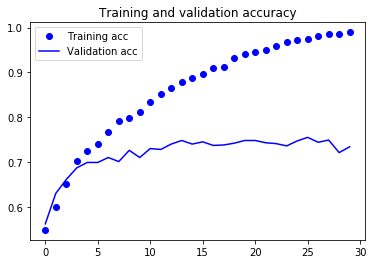

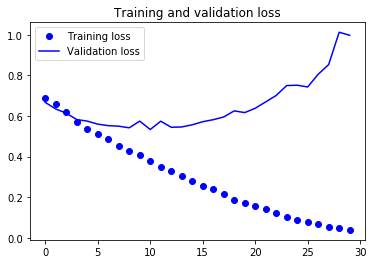

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Os gráficos mostram claramente o início do overfitting após 4 épocas de treino. Observe que no conjunto de treino a precisão aumenta e o erro diminui de forma continua até atingirem 100% e 0% respectivamente. Enquanto isso no conjunto de validação a precisão fica limitada em torno de 70% e o erro primeiro oscila e depois passa a crescer.

O overfitting neste caso era esperado pois o número de amostras para treino é pequeno (2.000). Nos exercícios anteriores foram vistas três técnicas gerais para lidar com o overfitting: reduzir o número de épocas de treino e regularizar os pesos da rede através das técnicas L1, L2, L1_L2 e de dropout. 

Vamos agora conhecer mais uma técnica para lidar com o overfitting, específica para problemas de reconhecimento de imagens: *data augmentation*.

## Reduzing o overfitting em problemas de reconhecimento de imagens através de *data augmentation*

A exposição contínua às mesmas poucas imagens leva ao overfitting. Sendo assim, à cada época de treino vamos "aumentar" a quantidade de imagens que o modelo irá observar durante o treino. 

Às novas imagens serão produzidas a partir das originais através de transformações aleatórias nos dados que produzirão novas imagens parecidas com às originais. A transformação pode ser o giro da imagem por um certo ângulo por exemplo.

O objetivo é que o modelo nunca veja exatamente a mesma imagem duas vezes. Isto irá ajudar o modelo a ser exposto a diferentes tipos de informação permitindo uma melhor generalização. 

A biblioteca Keras implementa a `data augmentation` através da indicação das faixas de transformação aleatória a serem executadas nas imagens que serão lidas pelo `ImageDataGenerator` antes de serem enviadas ao modelo. Observe o exemplo a seguir:

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Neste exemplo:

* `rotation_range=40`: indica que a imagem pode sofrer um giro de até 40 graus.
* `width_shift` e `height_shift`: o percentual de deslocamento vertical e horizontal que poderá ser aplicado nas imagens.
* `shear_range`: faixa percentual de transformação de cisalhamento (um deslocamento angular que "alonga" a imagem como se ela estivesse sendo "esticada" 
* `zoom_range`: faixa percentual do zoom que poderá ser aplicado.
* `horizontal_flip`: possibilidade de "flipar" (inverter) metade das imagens horizontalmente. 
* `fill_mode`: estratégia de preenchimento dos pixels que poderão aparecer após a rotação ou o deslocamento da imagem.

Vamos observar o efeito do `data augmentation` em algumas das imagens:

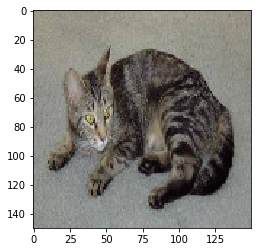

In [0]:
# Pacote de funções para pré-processamento das imagens
from keras.preprocessing import image

# Lista com todos os nomes de arquivo no diretório train_cats_dir
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# Escolhemos uma imagem para "aumentar"
img_path = fnames[3]

# Lemos e ajustamos o tamanho da mesma
img = image.load_img(img_path, target_size=(150, 150))

# Apresentamos a mesma para comparação posterior
plt.imshow(img)
plt.show()

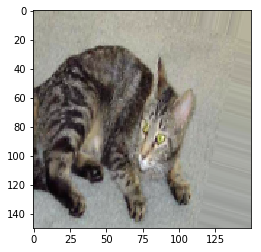

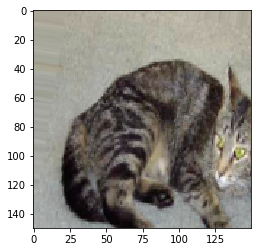

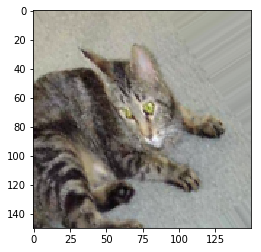

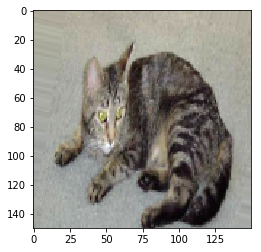

In [0]:
# Convertemos a mesma para um array numpy de formato (150, 150, 3)
x = image.img_to_array(img)

# Reformatamos o array para (1, 150, 150, 3) (o formato esperado pelo modelo)
x = x.reshape((1,) + x.shape)

# Lembrando: datagen é um objeto do tipo generator. Logo ele irá gerar dados
#  de forma contínua. Neste caso imagens aleatoriamente modificadas a partir
#  da imagem original. Sendo assim precisamos parar ("break") o loop em 
#  algum momento. Neste caso paramos o loop após a 4a imagem.

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i = i + 1
    if i % 4 == 0: break

plt.show()

Quando o modelo for treinado ela nunca irá ver exatamente a mesma imagem duas vezes. No entanto elas terão uma alta correlação, uma vez que vieram do mesmo conjunto de dados originais. Em outras palavras: não é possível gerar informação "nova", podemos apenas "embaralhar" a informação existente. 

Apenas o "embaralhar" de dados pode não ser suficiente para diminuir o overfitting. Sendo assim vamos incluir uma camada de Dropout entre a última camada convolutiva e a primeira camada densa do modelo:

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Procedemos agora com o treino do novo modelo com a camada de dropout no conjunto de dados de treino aumentado.

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Observe que os dados de validação não passa por data augmentation. 
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # diretório onde estão as imagens de treino
        target_size=(150, 150), # reajuste de tamanho para 150x150 pixels
        batch_size=32, 
        class_mode='binary') # será necessário o uso de rótulos binários pois 
                             # estamos usando como função de erro a binary_crossentropy

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 30s 299ms/step - loss: 0.6921 - acc: 0.5106 - val_loss: 0.6834 - val_acc: 0.5006
Epoch 2/100
100/100 [==============================] - 27s 270ms/step - loss: 0.6779 - acc: 0.5762 - val_loss: 0.6540 - val_acc: 0.6276
Epoch 3/100
100/100 [==============================] - 27s 273ms/step - loss: 0.6597 - acc: 0.6135 - val_loss: 0.6400 - val_acc: 0.6313
Epoch 4/100
100/100 [==============================] - 27s 269ms/step - loss: 0.6452 - acc: 0.6291 - val_loss: 0.6413 - val_acc: 0.6089
Epoch 5/100
100/100 [==============================] - 26s 257ms/step - loss: 0.6224 - acc: 0.6481 - val_loss: 0.5943 - val_acc: 0.6758
Epoch 6/100
100/100 [==============================] - 28s 283ms/step - loss: 0.6192 - acc: 0.6562 - val_loss: 0.5859 - val_acc: 0.6894
Epoch 7/100
100/100 [==============================] - 27s 269ms/step - loss: 0.5962 - acc: 0.6753 -

Como sempre salvamos o modelo em um outro arquivo do tipo .h5. Ele será usado em uma seção subsequente.

In [0]:
model.save('./modelos/cats_and_dogs_small_2.h5')

Vamos agora plotar a evolução do erro e da precisão durante o treino nos conjuntos de treino e validação.

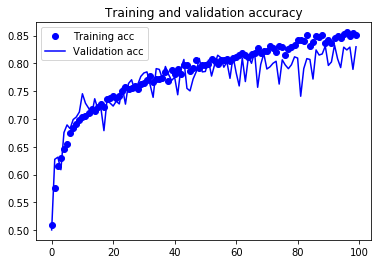

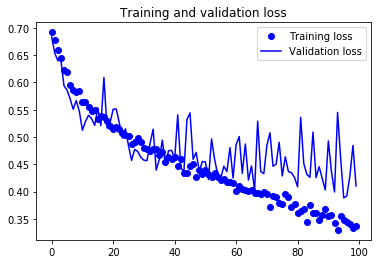

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Observe que com o uso da camada de dropout e do recurso de aumento de dados  o overfitting foi quase eliminado. As curvas de precisão e erro nos conjuntos de treino e validação estão quase sobrepostas. 

A precisão subiu para 80%, uma melhoria de aprox.15% em relação ao modelo anterior que não tinha pesos regularizados e cujos dados não passaram por aumento.

O uso de outras técnicas de regularização e a mudança dos hiper-parâmetros do modelo (por exemplo o número de filtros por camada convolutiva ou o número de camadas do modelo) poderíamos chegar em uma precisão próxima a 90%. 

No entanto ir além de 90% de precisão seria muito difícil apenas treinando a rede a partir do zero, uma vez que temos tão poucos dados.

No próximo tópico iremos melhorar a precisão do resultado final utilizando um modelo pré-treinado.